In [0]:
%matplotlib inline

# Seminario 1 : Aprender a construir redes neuronales simples

###Autores: 

Rafael López, lopgon.rafael@gmail.com

Jose Sanchez, josangar.sg@gmail.com




##Estructura del seminario

1. Definición de requisitos
2. Estructura de un proyecto de Deep Learning
3. Construcción de una red neuronal fully connected mediante Keras
4. Construcción de una red neuronal convolucional mediante Keras
5. Comparación de resultados
6. Conclusiones
7. Configuración del entorno de trabajo local





## 1. Definición de requisitos

### 1.1 Requisitos de software

#### Lenguaje de programación: 
  - Python 3.6
  
### Librerías:
  - **Tensorflow**: es una librería de software de código abierto para computación numérica, que utiliza gráficos de flujo de datos.
  
  - **Keras**: es un framework de alto nivel para el aprendizaje, escrito en Python y capaz de correr sobre los frameworks TensorFlow, CNTK, o Theano. Fue desarrollado con el objeto de facilitar un proceso de experimentación rápida.
  
  - **NumPy**: es una librería de Python, que le agrega mayor soporte para vectores y matrices, constituyendo una biblioteca de funciones matemáticas de alto nivel para operar con esos vectores o matrices.
  
  - **Matplotlib**: es una librería para la generación de gráficos a partir de datos contenidos en listas o arrays en el lenguaje de programación Python y su extensión matemática NumPy. 
  
 
[texto del enlace](https://)

### 1.2 Requisitos de datos

MNIST es un conjunto de datos de imagen público que consta de una imagen de 28 por 28 píxeles de un solo dígito escrita a mano. Cada imagen en MNIST es un dígito del 0 al 9. El desafío del MNIST es desarrollar un algoritmo de aprendizaje automático que pueda clasificar estas imágenes en 10 clases (0 a 9)

IMPORTAR IMAGEN DATASET

### 1.3 Importación de dependencias

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

from keras.datasets import mnist # Dataset a utilizar
from keras.models import Model # Modelo sobre el que se definen las redes neuronales
from keras.layers import Input, Dense, Dropout # Capas red fully connected
from keras.layers import Conv2D, MaxPool2D, Flatten # Capas red para convolucional
from keras.utils import np_utils # Utilidades para procesar datos

Using TensorFlow backend.


## 2. Estructura de un proyecto de Deep Learning

- Preparación del dataset
- Carga de datos
- Diseño de la arquitectura de la red neuronal
- Entrenamiento
- Evaluación del modelo


## 3. Construcción de una red neuronal fully connected mediante Keras



### 3.1 Carga de datos

In [0]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_testval, y_testval) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)


#### Visualización de datos

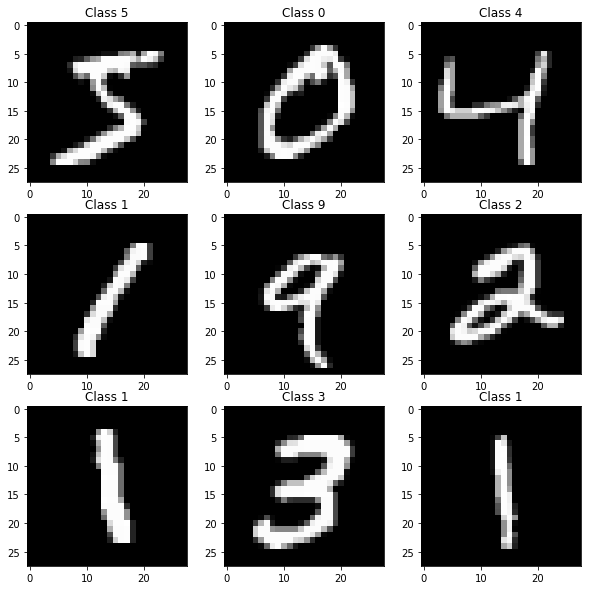

In [0]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

#### Preproceso de datos

- Reshape de la imagenes (2D) a vectores (1D)
- Convertir tipo de datos a coma flotante
- Normalización de rangos de intensidad de las imágenes a 0-1.

In [0]:
X_train = X_train.reshape(60000, 784)
X_testval = X_testval.reshape(10000, 784)
X_train = X_train.astype('float32')
X_testval = X_testval.astype('float32')
X_train /= 255
X_testval /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_testval.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


#### Preproceso de etiquetas

- One-hot-encoding

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

In [0]:
print('Y_train from 0 to 9')
print(y_train[:10])
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_testval = np_utils.to_categorical(y_testval, nb_classes)
print('Y_train onehot encoding')
print(Y_train[:10])

Y_train from 0 to 9
[5 0 4 1 9 2 1 3 1 4]
Y_train onehot encoding
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


#### Partición de datos de test en subset de validación y subset de test

In [0]:
X_val = X_testval[:int(X_testval.shape[0]/2)]
Y_val = Y_testval[:int(Y_testval.shape[0]/2)]
X_test = X_testval[int(X_testval.shape[0]/2):]
Y_test = Y_testval[int(Y_testval.shape[0]/2):]
y_test = np.argmax(Y_test, axis=1)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Validation matrix shape (5000, 784)
Testing matrix shape (5000, 784)



### 3.2 Diseño de la arquitectura de la red neuronal

figurade neurona y otra de red neuronal

In [0]:
input_layer = Input(shape=(X_train.shape[1],)) # Declaramos las dimensionesde los datos de entrada a la red
hidden_layer = Dense(32, activation='relu')(input_layer) # Definimos una capa oculta y su función de activación
output_layer = Dense(10, activation='softmax')(hidden_layer) # Definimos la capa de salida y su función de activación
model= Model(inputs=input_layer, outputs=output_layer) # Generamos el modelo de keras a partir de las capas que hemos definido
model.summary()

W0622 19:16:09.161606 140520866420608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 19:16:09.212095 140520866420608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0622 19:16:09.221232 140520866420608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


#### Compilación del modelo
Keras está construido sobre Tensorflow, el cuál permite definir un grafo de computación en Python que posteriormente se compila y se lanza de forma eficiente en la CPU (o GPU) sin utilizar el intérprete de Python.

Cuando se compila un modelo, debemos especificar la función de coste y el optimizador:
 
- **Función de coste**: define como se mide el error de la red en función de las diferencias entre las predicciones de la red y las etiquetas de los datos de entrenamiento.
- **Optimizador**: determina como aprende el modelo, es decir, como se propaga el error a la salida de la red por las diferentes capas de la misma. 




In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0622 19:16:09.271411 140520866420608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0622 19:16:09.312317 140520866420608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



### 3.3 Entrenamiento

- Definir batch_size
- Definir número de epochs (iteraciones de entrenamiento)
- Intruducir datos para la validación del entrenamiento

In [0]:
model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=4,
          verbose=1,
          validation_data=(X_val, Y_val)
         )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.
W0622 19:16:09.638117 140520866420608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0622 19:16:09.693241 140520866420608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 5000 samples
Epoch 1/4
60000/60000 [==============================] - 2s 34us/step - loss: 0.5045 - acc: 0.8632 - val_loss: 0.3535 - val_acc: 0.8988
Epoch 2/4
60000/60000 [==============================] - 1s 22us/step - loss: 0.2521 - acc: 0.9289 - val_loss: 0.2836 - val_acc: 0.9170
Epoch 3/4
60000/60000 [==============================] - 1s 22us/step - loss: 0.2107 - acc: 0.9411 - val_loss: 0.2560 - val_acc: 0.9268
Epoch 4/4
60000/60000 [==============================] - 1s 22us/step - loss: 0.1820 - acc: 0.9483 - val_loss: 0.2335 - val_acc: 0.9356


### 3.4 Evaluación del modelo

#### Obtención de métricas

In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.12623495618402958
Test accuracy: 0.966


#### Inspección de las predicciones

In [0]:
# Predecimos las clases de los datos de test y las post-procesamos para trabajar
# cómodament con ellas
predicted_classes = model.predict(X_test)
predicted_classes = np.round(predicted_classes)
predicted_classes = np.argmax(predicted_classes, axis=1)

# Obtenemos los índices de las muestras que se han predecido correcta e 
# incorrectamente para mostrarlas posteriomente
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

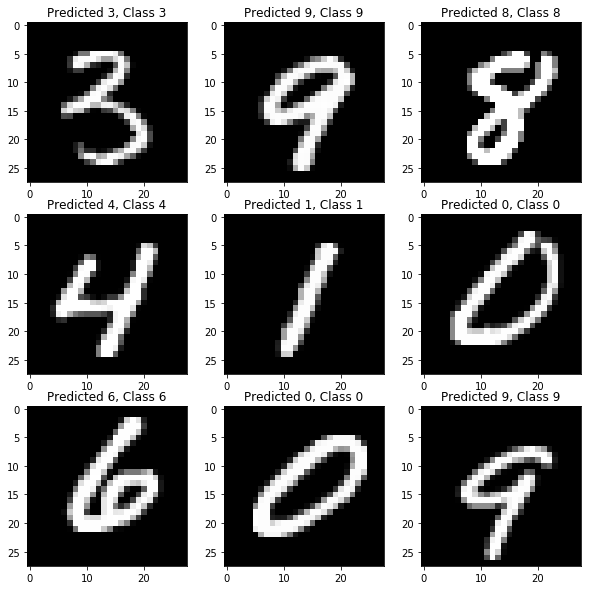

In [0]:
# Mostramos muestras correctamente clasificadas
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

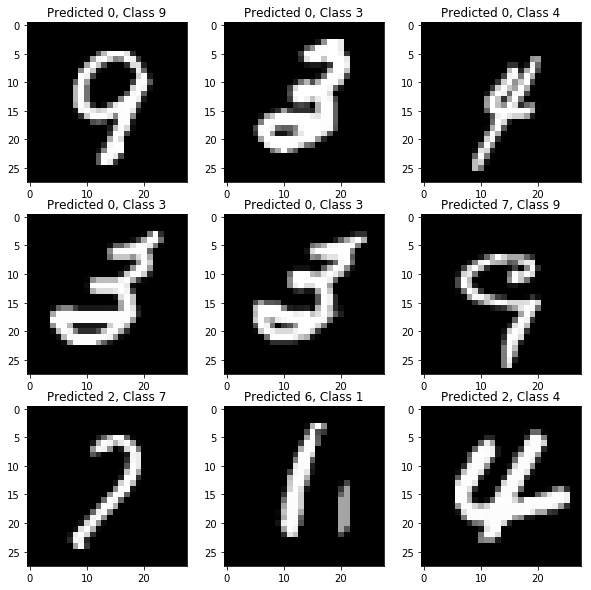

In [0]:
# Mostramos muestras incorrectamente clasificadas
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

### 3.5 Añadiendo complejidad al modelo

#### Añadir más neuronas a la capa oculta

In [0]:
# Diseño de la arquitectura de la red neuronal
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer = Dense(512, activation='relu')(input_layer)
output_layer = Dense(10, activation='softmax')(hidden_layer)
model= Model(inputs=input_layer, outputs=output_layer)
model.summary()

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento
model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=4,
          verbose=1,
          validation_data=(X_val, Y_val)
         )

# Obtención de métricas
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 60000 samples, validate on 5000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 97us/step - loss: 0.2686 - acc: 0.9247 - val_loss: 0.1756 - val_acc: 0.9464
Epoch 2/4
60000/60000 [==============================] - 6s 94us/step - loss: 0.1082 - acc: 0.9694 - val_loss: 0.1266 - val_acc: 0.9596
Epoch 3/4
60000/60000 [==============================] - 6s 94us/step - loss: 0.0692 - acc: 0.9798 - val_loss: 0.1054 - val_acc: 0.9658
Epoch 4/4
60000/60000 [==============================] - 6s 93us/step - loss: 0.0501 - acc: 0.9852 - val_loss: 0.0851 - val_acc: 0.9726
Test score: 0.04939889519829303
Test accuracy: 0.9848


#### Añadir más capas ocultas

In [0]:
# Diseño de la arquitectura de la red neuronal
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer_1 = Dense(512, activation='relu')(input_layer)
hidden_layer_2 = Dense(512, activation='relu')(hidden_layer_1)
output_layer = Dense(10, activation='softmax')(hidden_layer_2)
model= Model(inputs=input_layer, outputs=output_layer)
model.summary()

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento
model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=4,
          verbose=1,
          validation_data=(X_val, Y_val)
         )

# Obtención de métricas
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 60000 samples, validate on 5000 samples
Epoch 1/4
60000/60000 [==============================] - 9s 158us/step - loss: 0.2186 - acc: 0.9360 - val_loss: 0.1277 - val_acc: 0.9600
Epoch 2/4
60000/60000 [==============================] - 9s 153us/step - loss: 0.0791 - acc: 0.9753 - val_loss: 0.0994 - val_acc: 0.9676
Epoch 3/4
60000/60000 [==============================] - 9s 156us/step - loss: 0.0520 - acc: 0.9841 - val_loss: 0.0874 - val_acc: 0.9708
Epoch 4/4
60000/60000 [==============================] - 9s 152us/step - loss: 0.0350 - acc: 0.9890 - val_loss: 0.0992 - val_acc: 0.9718
Test score: 0.04513814133445267
Test accuracy: 0.9858


#### Añadimos dropout para evitar overfitting

poner imagen overfitting

In [0]:
# Diseño de la arquitectura de la red neuronal
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer_1 = Dense(512, activation='relu')(input_layer)
dropout_1 = Dropout(0.2)(hidden_layer_1)
hidden_layer_2 = Dense(512, activation='relu')(hidden_layer_1)
dropout_2 = Dropout(0.2)(hidden_layer_2)
output_layer = Dense(10, activation='softmax')(dropout_2)
model= Model(inputs=input_layer, outputs=output_layer)
model.summary()

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento
model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=4,
          verbose=1,
          validation_data=(X_val, Y_val)
         )

# Obtención de métricas
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

W0622 19:17:19.708700 140520866420608 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 5000 samples
Epoch 1/4
60000/60000 [==============================] - 10s 169us/step - loss: 0.2290 - acc: 0.9323 - val_loss: 0.1343 - val_acc: 0.9570
Epoch 2/4
60000/60000 [==============================] - 10s 160us/step - loss: 0.0844 - acc: 0.9743 - val_loss: 0.1026 - val_acc: 0.9638
Epoch 3/4
60000/60000 [==============================] - 10s 160us/step - loss: 0.0548 - acc: 0.9831 - val_loss: 0.1022 - val_acc: 0.9674
Epoch 4/4
60000/60000 [==============================] - 10s 161us/step - loss: 0.0392 - acc: 0.9876 - val_loss: 0.0885 - val_acc: 0.9718
Test score: 0.041081462171464224
Test accuracy: 0.9874


## 4. Construcción de una red neuronal convolucional mediante Keras

imagen de redes neuronales convolucionales

### 4.1 Carga de datos

#### Preproceso de datos
- Reshape a tamaño 28x28x1

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28)[..., np.newaxis]
X_val = X_val.reshape(X_val.shape[0], 28, 28)[..., np.newaxis]
X_test = X_test.reshape(X_test.shape[0], 28, 28)[..., np.newaxis]
print("X_train dimensions", X_train.shape)
print("X_val dimensions", X_val.shape)
print("X_test dimensions", X_test.shape)

X_train dimensions (60000, 28, 28, 1)
X_val dimensions (5000, 28, 28, 1)
X_test dimensions (5000, 28, 28, 1)


### 4.2 Diseño de la arquitectura de la red neuronal convolucional

In [0]:
input_layer = Input(shape=(X_train.shape[1],X_train.shape[2], 1))
conv_layer_1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_layer)
maxpool_layer_1 = MaxPool2D(pool_size=(2, 2))(conv_layer_1)
conv_layer_2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(maxpool_layer_1)
maxpool_layer_2 = MaxPool2D(pool_size=(2, 2))(conv_layer_2)
conv_layer_3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(maxpool_layer_2)
flatten_layer = Flatten()(conv_layer_3)
dense_layer = Dense(128, activation='relu')(flatten_layer)
output_layer = Dense(10, activation='softmax')(dense_layer)
model= Model(inputs=input_layer, outputs=output_layer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 32)          4640      
_________________________________________________________________
flatten_4 (Flatten)          (None, 288)               0         
__________

#### Compilación


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 4.3 Entrenamiento

In [0]:
model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=4,
          verbose=1,
          validation_data=(X_val, Y_val)
         )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 60000 samples, validate on 5000 samples
Epoch 1/4
60000/60000 [==============================] - 21s 349us/step - loss: 0.3662 - acc: 0.8900 - val_loss: 0.1278 - val_acc: 0.9612
Epoch 2/4
60000/60000 [==============================] - 20s 334us/step - loss: 0.0913 - acc: 0.9717 - val_loss: 0.0888 - val_acc: 0.9726
Epoch 3/4
60000/60000 [==============================] - 20s 334us/step - loss: 0.0650 - acc: 0.9797 - val_loss: 0.0631 - val_acc: 0.9770
Epoch 4/4
60000/60000 [==============================] - 20s 335us/step - loss: 0.0535 - acc: 0.9832 - val_loss: 0.0593 - val_acc: 0.9808


### 4.4 Evaluación del modelo

#### Obtención de métricas


In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

NameError: ignored

There are lots of other great examples at the Keras homepage at http://keras.io and in the source code at https://github.com/fchollet/keras